# Introduction 

In this notebook, we get the initially cleaned eviction data and turn it into geodataframe. By aggregating based on bbl, we visualized the eviction distribution in nyc with plotly and folium. Finally, we re-org the table to get the top 20 buildings with the most evictions happened on average per year during 2017 - 2024. Further analysis will continue in the same series notebooks until clustering analysis and getting to know the data is done. 

In [3]:
# !pip install geopandas folium matplotlib seaborn scipy
# !pip install esda
# !pip install splot
# # for google colab, had to reinstall some pacakges.

In [ ]:
# !pip install geopandas folium matplotlib seaborn scipy esda splot

In [4]:
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime as dt
import scipy

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# visualization
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns
import folium
from folium.plugins import HeatMap
from folium import Marker
from folium.plugins import MarkerCluster
import plotly.express as px
import plotly.io as pio

# spatial statistics
from esda.moran import Moran
from esda.getisord import G_Local
from libpysal.weights import Queen, Rook

# system and utility
import warnings
import os
import io
from IPython.display import IFrame
from google.colab import files

from libpysal.weights import Queen, Rook
from esda.moran import Moran
import matplotlib.pyplot as plt
from splot.esda import moran_scatterplot

# suppress warnings
warnings.filterwarnings('ignore')

# inline
%matplotlib inline

# Part 1 Get the Eviction data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# data source:
file_path = '/content/drive/My Drive/X999/evictions_df_cleaned.csv'

In [7]:
evictions_df_raw = pd.read_csv(file_path)

In [8]:
evictions_df = evictions_df_raw.copy()

In [9]:
evictions_df.head(2)

court_index_number  docket_number eviction_address  \
0         *313639/23           5202  710 61ST STREET   
1         *324973/22           5308  462 60TH STREET   

  eviction_apartment_number executed_date   borough  eviction_postcode  \
0                 2ND FLOOR    2024-03-04  BROOKLYN              11220   
1      FOURTH FLOOR APT AKA    2024-08-13  BROOKLYN              11220   

          ejectment eviction/legal_possession   latitude  longitude  \
0  Not an Ejectment                Possession  40.635941 -74.011883   
1  Not an Ejectment                Possession  40.640008 -74.017068   

   community_board  council_district  census_tract        bin           bbl  \
0              7.0              38.0         118.0  3143881.0  3.057940e+09   
1              7.0              38.0         122.0  3143435.0  3.057820e+09   

                nta  
0  Sunset Park East  
1  Sunset Park West

In [10]:
evictions_df.columns, \
evictions_df.shape

(Index(['court_index_number', 'docket_number', 'eviction_address',
        'eviction_apartment_number', 'executed_date', 'borough',
        'eviction_postcode', 'ejectment', 'eviction/legal_possession',
        'latitude', 'longitude', 'community_board', 'council_district',
        'census_tract', 'bin', 'bbl', 'nta'],
       dtype='object'),
 (76484, 17))

In [11]:
evictions_df.executed_date = pd.to_datetime(evictions_df.executed_date)

In [12]:
evictions_df.executed_date.min(), evictions_df.executed_date.max()

(Timestamp('2017-01-03 00:00:00'), Timestamp('2024-09-16 00:00:00'))

# Part 2 Get to know the GeoDataFrame

#### To properly understand the geo features and find hot spots in this evcition datasets, we need to utilize the GeoDataFrame to see if there is any interesting patterns that could be attributed to Societal trends/Predatory landlord bahaviors/corporate landlord behaviors

In [13]:
# first, we create a GeoDataFrame
evictions_gdf = gpd.GeoDataFrame(
    evictions_df,
    geometry=gpd.points_from_xy(evictions_df['longitude'], evictions_df['latitude']))

In [14]:
evictions_gdf.head(2)

court_index_number  docket_number eviction_address  \
0         *313639/23           5202  710 61ST STREET   
1         *324973/22           5308  462 60TH STREET   

  eviction_apartment_number executed_date   borough  eviction_postcode  \
0                 2ND FLOOR    2024-03-04  BROOKLYN              11220   
1      FOURTH FLOOR APT AKA    2024-08-13  BROOKLYN              11220   

          ejectment eviction/legal_possession   latitude  longitude  \
0  Not an Ejectment                Possession  40.635941 -74.011883   
1  Not an Ejectment                Possession  40.640008 -74.017068   

   community_board  council_district  census_tract        bin           bbl  \
0              7.0              38.0         118.0  3143881.0  3.057940e+09   
1              7.0              38.0         122.0  3143435.0  3.057820e+09   

                nta                    geometry  
0  Sunset Park East  POINT (-74.01188 40.63594)  
1  Sunset Park West  POINT (-74.01707 40.64001)

In [15]:
evictions_cleaned = evictions_gdf.dropna(subset=['latitude', 'longitude'])
evictions_cleaned = evictions_cleaned.reset_index(drop=True)

In [16]:
evictions_cleaned.columns

Index(['court_index_number', 'docket_number', 'eviction_address',
       'eviction_apartment_number', 'executed_date', 'borough',
       'eviction_postcode', 'ejectment', 'eviction/legal_possession',
       'latitude', 'longitude', 'community_board', 'council_district',
       'census_tract', 'bin', 'bbl', 'nta', 'geometry'],
      dtype='object')

### Part 2.1: Aggregation to find eviction counts (with BBL)

#### Aggregate by BBL:

BBL appears to be the most sensible basic unit here, as other ones: apartment unit, neighborhood, zipcode, and borough would either be too small (non-representable) or too large to understand landlord behaviors.

In [17]:
# groupby
evictions_by_bbl = evictions_cleaned.groupby('bbl').size().reset_index(name='eviction_count')
# merge
evictions_cleaned = evictions_cleaned.merge(evictions_by_bbl, on='bbl', how='left')

In [18]:
evictions_cleaned.columns
# eviction_count added

Index(['court_index_number', 'docket_number', 'eviction_address',
       'eviction_apartment_number', 'executed_date', 'borough',
       'eviction_postcode', 'ejectment', 'eviction/legal_possession',
       'latitude', 'longitude', 'community_board', 'council_district',
       'census_tract', 'bin', 'bbl', 'nta', 'geometry', 'eviction_count'],
      dtype='object')

In [19]:
# normalize the eviction counts by year and get the average counts:
evictions_cleaned['year'] = evictions_cleaned['executed_date'].dt.year  # Extract year from executed_date
eviction_counts = evictions_cleaned.groupby(['bbl', 'year']).size().reset_index(name='eviction_count')
yearly_avg_evictions = eviction_counts.groupby('bbl')['eviction_count'].mean().reset_index(name='average_year_eviction_count')

In [20]:
# merge
evictions_cleaned = evictions_cleaned.merge(yearly_avg_evictions, on='bbl', how='left')

In [21]:
evictions_cleaned.columns
# average_year_eviction_count added

Index(['court_index_number', 'docket_number', 'eviction_address',
       'eviction_apartment_number', 'executed_date', 'borough',
       'eviction_postcode', 'ejectment', 'eviction/legal_possession',
       'latitude', 'longitude', 'community_board', 'council_district',
       'census_tract', 'bin', 'bbl', 'nta', 'geometry', 'eviction_count',
       'year', 'average_year_eviction_count'],
      dtype='object')

In [22]:
evictions_cleaned.head(2)

court_index_number  docket_number eviction_address  \
0         *313639/23           5202  710 61ST STREET   
1         *324973/22           5308  462 60TH STREET   

  eviction_apartment_number executed_date   borough  eviction_postcode  \
0                 2ND FLOOR    2024-03-04  BROOKLYN              11220   
1      FOURTH FLOOR APT AKA    2024-08-13  BROOKLYN              11220   

          ejectment eviction/legal_possession   latitude  ...  \
0  Not an Ejectment                Possession  40.635941  ...   
1  Not an Ejectment                Possession  40.640008  ...   

   community_board  council_district  census_tract        bin           bbl  \
0              7.0              38.0         118.0  3143881.0  3.057940e+09   
1              7.0              38.0         122.0  3143435.0  3.057820e+09   

                nta                    geometry eviction_count  year  \
0  Sunset Park East  POINT (-74.01188 40.63594)              3  2024   
1  Sunset Park West  POINT (-74.01707 40.64001)              3  2024   

   average_year_eviction_count  
0                          3.0  
1                          3.0  

[2 rows x 21 columns]

### Part 2.2 Visualize the GeoDataFrame -- Plotly and Folium

#### Plotly first:

In [ ]:
# scatter map showing eviction counts by BBL
# a very basic and high-level visualization of each building's annual eviction during the year 2017 -2024
# the outlines are clear. They are the lighter and orange ones.
fig = px.scatter_geo(evictions_cleaned,
                     lat='latitude', lon='longitude',
                     color='average_year_eviction_count',
                     hover_name='bbl',
                     title="Evictions by BBL in NYC")

fig.update_geos(scope='usa', fitbounds="locations")
fig.show()

Saving plotly_image.png to plotly_image.png


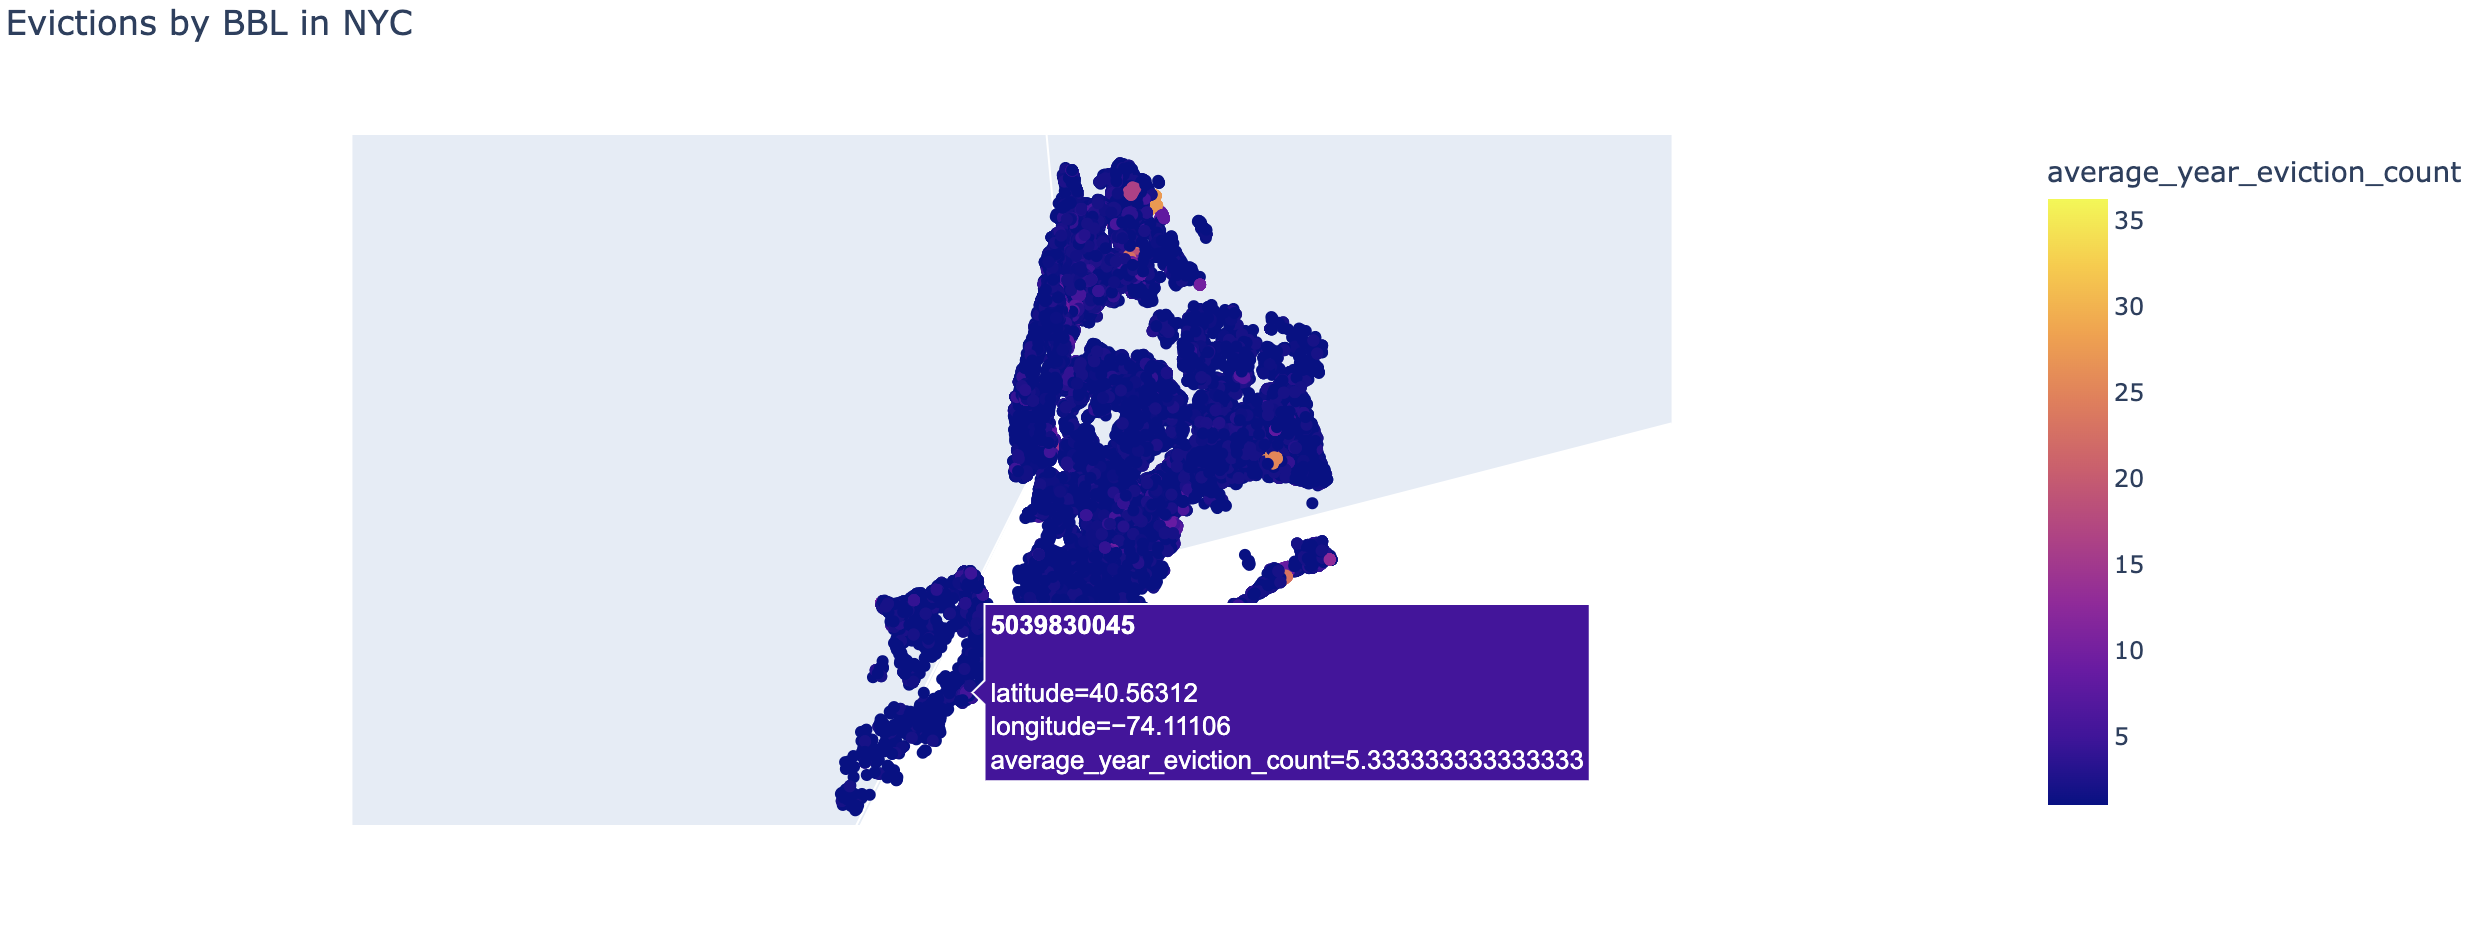

In [ ]:
# in case the graph does not load, it is as shown below
# it is originally an interactive graph where if you point to a building, you get the bbl id, laititude, longitude, and
# the annual eviction counts
from google.colab import files
from IPython.display import Image
uploaded = files.upload()
Image(filename='plotly_image.png')

In [ ]:
# save as an interactive HTML file
pio.write_html(fig, file='evictions_map.html', auto_open=False)

#### Short summaries:  
- What Plotly shows here is that certain buildings have more evictions than others. Most buildings have fewer than 5 evictions per year, but a few of them have more than 20 evictions per year on average during the year 2017 to 2024.


### Folium:

In [ ]:
# use folium heatmap to show the data in a better visualization
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)
heat_data = [[row['latitude'], row['longitude'], row['average_year_eviction_count']] for index, row in evictions_cleaned.iterrows()]
HeatMap(heat_data, radius=10).add_to(nyc_map)

nyc_map

Saving heat_map.png to heat_map.png


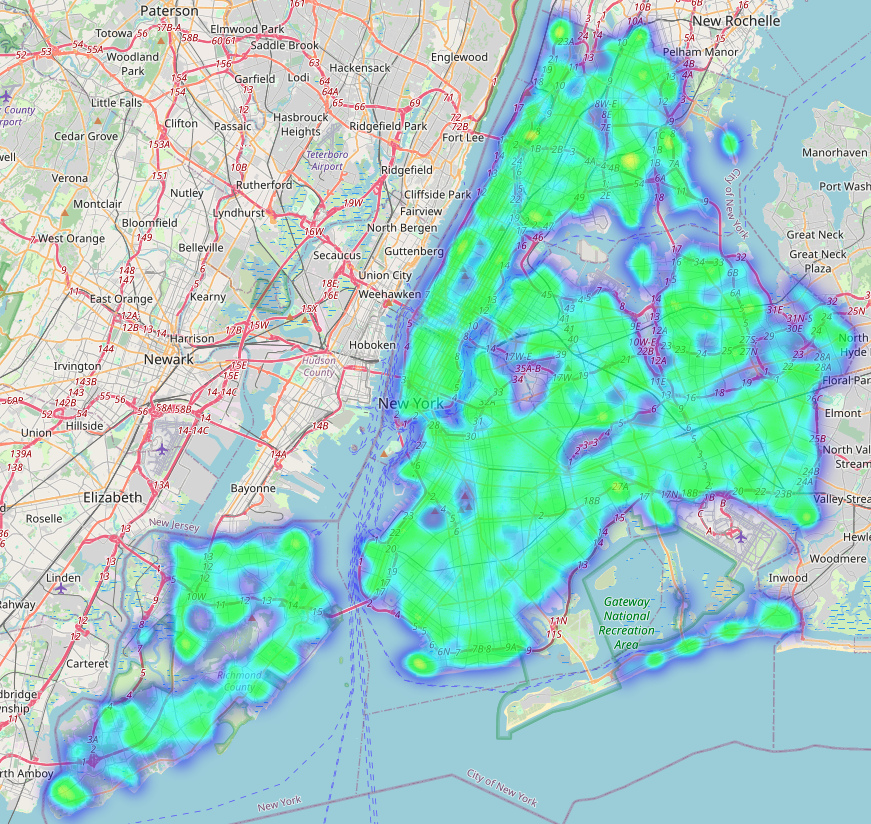

In [ ]:
# in case it does not load, it is as shown below
from google.colab import files
from IPython.display import Image
uploaded = files.upload()
Image(filename='heat_map.png')

#### Short summaries:
- Folium heatmap gives the same conclusion: most buildings have very few evictions per year, usually 1, with a little more than a dozen buildings have more than 10 evictions per year. However, Folium map shows better details of the streets and neighborhoods.

# Part 3 Clustering

In [ ]:
# evictions_cleaned.columns
## didn't change

In [ ]:
# the number of unique building codes is 34032 in this dataset
len(evictions_cleaned.bbl.unique())

34032

In [ ]:
evictions_cleaned.shape
# as expected, there are repeatitive bbl with evictions over the years

(76484, 21)

## Part 3.1 Buildings with the most evictions (top_bbls)

In [ ]:
# sort by eviction_count and extract the top 10 records based on the average_year_eviction_count column
top_bbls = evictions_cleaned[['bbl', 'average_year_eviction_count']].groupby('bbl').mean().sort_values(by='average_year_eviction_count', ascending=False)
top_bbls.shape

(34032, 1)

In [ ]:
top_bbls.head(10)

average_year_eviction_count
bbl                                      
2.028820e+09                    36.285714
2.051410e+09                    27.428571
4.124950e+09                    25.428571
4.159260e+09                    23.000000
2.039448e+09                    22.714286
2.039438e+09                    18.714286
2.049050e+09                    16.333333
3.042719e+09                    14.571429
1.003560e+09                    14.333333
3.036280e+09                    13.714286

In [ ]:
bbls_over_10_evictions = top_bbls[top_bbls['average_year_eviction_count'] > 10]
bbls_over_10_evictions.shape
# 18 buildings have eviction counts larger than 10 per year on average

(18, 1)

### TODO: 
### Some potential research questions/hypothesis include: 
    - look into each of these buildings and check who the landlords are.
    - are they individual landlord or corporate landlords?
    - do they habitually exbihit such behavior?
    - is there a reason for the evictions besides the tenants' behavior?
    - is this related to building policy changes?
    - is this related to city-wide/neighborhood-wide changes?
### Another dataset we will be using: BBL.csv
    - pull the info of the buildings from bbl
    - since there are only 18 of them, we can have a closer look at them and then get a writeup of the landlords' background.

In [ ]:
# show all 18 of them

bbls_over_10_evictions

average_year_eviction_count
bbl                                      
2.028820e+09                    36.285714
2.051410e+09                    27.428571
4.124950e+09                    25.428571
4.159260e+09                    23.000000
2.039448e+09                    22.714286
2.039438e+09                    18.714286
2.049050e+09                    16.333333
3.042719e+09                    14.571429
1.003560e+09                    14.333333
3.036280e+09                    13.714286
4.156100e+09                    12.857143
2.045060e+09                    12.714286
2.045060e+09                    12.142857
2.026100e+09                    11.250000
2.026188e+09                    10.857143
2.039388e+09                    10.857143
3.049810e+09                    10.428571
5.012720e+09                    10.166667

In [ ]:
evictions_cleaned.head(2)

court_index_number  docket_number eviction_address  \
0         *313639/23           5202  710 61ST STREET   
1         *324973/22           5308  462 60TH STREET   

  eviction_apartment_number executed_date   borough  eviction_postcode  \
0                 2ND FLOOR    2024-03-04  BROOKLYN              11220   
1      FOURTH FLOOR APT AKA    2024-08-13  BROOKLYN              11220   

          ejectment eviction/legal_possession   latitude  ...  \
0  Not an Ejectment                Possession  40.635941  ...   
1  Not an Ejectment                Possession  40.640008  ...   

   community_board  council_district  census_tract        bin           bbl  \
0              7.0              38.0         118.0  3143881.0  3.057940e+09   
1              7.0              38.0         122.0  3143435.0  3.057820e+09   

                nta                    geometry eviction_count  year  \
0  Sunset Park East  POINT (-74.01188 40.63594)              3  2024   
1  Sunset Park West  POINT (-74.01707 40.64001)              3  2024   

   average_year_eviction_count  
0                          3.0  
1                          3.0  

[2 rows x 21 columns]

In [ ]:
# evictions_cleaned.columns
## no change

#### The rest of the analysis will be broken down into different notebooks